### Laboratorio de Escalonamento ###

Neste laboratório, iremos simular o funcionamento de algoritmos de escalonamento básicos para entender melhor seu funcionamento.

Na célula abaixo, temos uma classe Processo, que tem as informações de execução, e uma classe de exemplo de escalonamento apenas com os protótipos:

(orientação a objeto em Python)

Na célula abaixo, são criados quatro processos completamente CPU-Bound que precisam de 3 timeslices para rodar.

O valor de E/S é um número entre 0 e 100 indicando quantos porcento de chance o processo tem de fazer E/S durante seu tempo na CPU

In [25]:
import numpy as np

import random

class Processo(object):
    def __init__(self,pnome,pio,ptam,prioridade,tempoChegada,bilhetes=0):
        self.nome = pnome
        self.io = pio # Probabilidade de fazer E/S, inicialmente zero
        self.tam = ptam # Quantos Timeslices sao necessarios para terminar
        self.prio = prioridade # Prioridade, eh desnecessaria agora 
        self.chegada = 0
        self.bilhetes = bilhetes
        self.stride = 0
        self.passadas = 0
        self.NFila = 0
        self.primeira_execucao = True
        
        
    def roda(self,quantum=None): # se rodar sem quantum, o processor roda ate o fim
        if(random.randint(1,100)<self.io): #Verifica se fez E/S
            self.tam-=1
            print(self.nome," fez e/s, falta ",self.tam)
            return 1, True #True que fez E/S
            
            
        if(quantum is None or self.tam<quantum):
            quantum = self.tam
        self.tam -=quantum
        print(self.nome," rodou por ",quantum," timeslice, faltam ",self.tam)
        return quantum, False # False se nao fez E/S
   


In [26]:
#Montando o escalonador Round-robin

class round_robin(object):
    
    def __init__(self,vprontos=[]):
        self.prontos = vprontos #processos que chegam ao tempo zero
        
    def pronto(self,Processo):
        # implemente aqui o que escalonador faz quando surge um novo processo pronto
        self.prontos.append(Processo) #vai colocar o processo pronto no ultimo elemento do meu vetor
    
    def proximo(self):
        # implemente aqui a politica de escalonamento para definir um processo a ser executado
        if len(self.prontos) > 0: 
            return self.prontos.pop(0) 
        else:
            return None


In [27]:
class escalonador_MLFQ(object):
    def __init__(self, vprontos=[], NFila=3, quantums=None):
        self.NFila = NFila
        self.quantums = quantums if quantums is not None else [2] * NFila
        self.prontos = [[] for _ in range(NFila)]
        for p in vprontos:
            p.NFila = 0
            self.prontos[0].append(p)

    def pronto(self, processo, motivo="novo"):
        nivel = processo.NFila
        if motivo == "novo":
            processo.NFila = 0
            print("Processo", processo.nome, "entrou na fila de n°", processo.NFila)
            self.prontos[0].insert(0, processo)  # insere no começo da fila 0
            return
        elif motivo == "io":
            print("Processo", processo.nome, "manteve-se na fila n°", processo.NFila)
        elif motivo == "desinteresse":
            if nivel < self.NFila - 1:
                processo.NFila += 1
            print("Processo", processo.nome, "desceu para fila de n°", processo.NFila)
            
        self.prontos[processo.NFila].append(processo)  # outros casos, vai no final

    def proximo(self):
        for i in range(self.NFila):
            if self.prontos[i]:
                p = self.prontos[i].pop(0)
                return p
        return None

    def get_quantum(self, processo):
        return self.quantums[processo.NFila]
    
    def boost(self):
        todos_processos = []
        for i in range(1, self.NFila):  # Pula a fila 0
            while self.prontos[i]:
                p = self.prontos[i].pop(0)
                p.NFila = 0
                todos_processos.append(p)
        for p in todos_processos:
            print(f"Processo {p.nome} subiu para fila n° 0")
            self.prontos[0].append(p)



In [28]:
class escalonador_Loteria(object):
    
    def __init__(self,vprontos=[]):
        self.prontos = sorted(vprontos,key=lambda p:p.bilhetes, reverse=True)#vai ordenar decresente do maior bilhete para o menor 
    
    def pronto(self,Processo):
        self.prontos.append(Processo)#vai colocar o bilhete na fila
        self.prontos = sorted(self.prontos,key=lambda p:p.bilhetes, reverse=True)#depois que ele colocar ele vai ordenar 
        
    def proximo(self):
        total = 0
        for i in range(len(self.prontos)):
            total += self.prontos[i].bilhetes #vai pegar o total de bilhetes
        
        if total == 0:
            return None
        
        acon = 0 #vai acumular os processos que ainda nao esta na rodando 
        random2 = random.randrange(total)#vai pegar o valor aleatorio com base total de bilhetes 
        
        for j in range(len(self.prontos)):
            
            if random2 < self.prontos[j].bilhetes + acon:
                return self.prontos.pop(j)#vai rodar o processo e tira na fila
            else:
                acon += self.prontos[j].bilhetes #vai acumular os processos que nao foi escolhido 
        

In [29]:

class escalonador_stride(object):
    
    def __init__(self,vprontos=[]):
        self.prontos = vprontos
        
    def pronto(self,Processo):
        self.prontos.append(Processo)
        
    def proximo(self):
        
        if len(self.prontos) == 0: 
            return None
        
        total = 0
        for i in range(len(self.prontos)):
            total += self.prontos[i].bilhetes #vai pegar o total de bilhetes 
        
        global2 = tempo * 2
        
        for j in range(len(self.prontos)):
            self.prontos[j].stride = global2/self.prontos[j].bilhetes #vou dividir pela minha variavel global para ter o tamanho das minhas passadas
     
        menor = 0
        
        for k in range(1, len(self.prontos)):
            if((self.prontos[k].passadas) < (self.prontos[menor].passadas)):
                menor = k 
                
        self.prontos[menor].passadas += self.prontos[menor].stride
        return self.prontos.pop(menor) 
        

In [30]:
nprocs = 3
nomes = ['A','B','C']
chanceio = [0,0,0] #Valor de zero a cem, chance de ser entrada e saida por enquanto deixem em zero
tamanho = np.array([10,10,10])

bilhetes =  [100,100,100] 


total = tamanho.sum()

procs = []
for i in range(nprocs):
    procs.append(Processo(nomes[i],chanceio[i],tamanho[i],0,0,bilhetes[i])) #cria uma lista procs de Processos
    

Na célula abaixo, temos o mesmo simulador do laboratório anterior:

In [31]:
quantum = 100
tempoBloq = 1

escalonador =   escalonador_stride(procs)# troque escalonador pelo seu escalonador
bloqueados = []

tempo = 0

tempo_excucao = []

random.seed(0)

while total > 0:
    p = escalonador.proximo()
    if p is not None:
        rodou, _ = p.roda(quantum)  # quantum como parâmetro

        if p.tam > 0:
            escalonador.pronto(p)
        total -= rodou
        tempo += rodou
        
        if p.tam == 0:
            tempo_excucao.append(tempo)
    else:
        tempo += 1
        # Aqui você poderia também atualizar bloqueados, se houvesse E/S
        

        
U = tempo_excucao[0] / tempo_excucao[-1]  #injustica 

print("Calculo de injustiça: ",U)


A  rodou por  10  timeslice, faltam  0
B  rodou por  10  timeslice, faltam  0
C  rodou por  10  timeslice, faltam  0
Calculo de injustiça:  0.3333333333333333


Nesta, temos um simulador avançado, com E/S e novos processos chegando em momentos diferentes:

In [32]:
quantum = 2
tempoBloq = 2

escalonador = escalonador_Loteria(procs)
bloqueados = []


maximo = 10
chanceNovoProcesso = 60
chanceIo = 30
minTime = 4
maxTime = 10


contaProc = 1

tempo = 0


tempo_resposta = 0 

tempo_execuçao = 0 

cont_procs_novos = 0
#descomente essa linha caso queira que os random sempre dêem o mesmo resultado
random.seed(0)

while tempo<maximo or len(escalonador.prontos)>0:
    
    #Novo processo tem chanceProcesso% de chance surgir enquanto o tempo não chegar no máximo
    if(tempo<maximo and random.randint(1,100)<chanceNovoProcesso):
        
        num = random.choice([10,20,50]); #COLOCADO PARA FAZER A 4 QUESTAO DA LOTERIA 
        
        p = Processo('P'+str(contaProc),random.randint(1,chanceIo),random.randint(minTime,maxTime),0,tempo,num)
        print("Processo",p.nome," chegou no tempo",tempo)
        escalonador.pronto(p)
        contaProc+=1
        
    p = escalonador.proximo()
    
    if(p is not None):
        if(p.primeira_execucao):
            tempo_resposta += tempo - p.chegada
            print(tempo_resposta)
            p.primeira_execucao = False 
        rodou, fezio = p.roda(quantum)
        if(fezio and p.tam>0):
            bloqueados.append([p,tempoBloq+1]) #Adiciona o processo que fez e/s aos bloqueados 
        elif(p.tam>0):
            escalonador.pronto(p)
        total-=rodou
        tempo+=rodou
        
        if(p.tam == 0):
            tempo_execuçao += tempo
        
        
    else:
        #Reduz o tempo de todos os bloqueados em uma unidade
        tempo+=1
    if(len(bloqueados)>0):
        for i in bloqueados:
            i[1]-=1
            if(i[1] == 0):
                escalonador.pronto(i[0])
                del i  
                
                
                
print("Tempo de Execuçao medio:",tempo_execuçao/contaProc)
print("Tempo de Resposta: ",tempo_resposta/contaProc)

Processo P1  chegou no tempo 0
0
P1  rodou por  2  timeslice, faltam  4
Processo P2  chegou no tempo 2
2
P2  rodou por  2  timeslice, faltam  4
P1  rodou por  2  timeslice, faltam  2
Processo P3  chegou no tempo 6
P2  rodou por  2  timeslice, faltam  2
P2  rodou por  2  timeslice, faltam  0
P1  rodou por  2  timeslice, faltam  0
14
P3  rodou por  2  timeslice, faltam  8
P3  rodou por  2  timeslice, faltam  6
P3  fez e/s, falta  5
Tempo de Execuçao medio: 5.5
Tempo de Resposta:  3.5


## ÁREA DO MLFQ

In [33]:
nprocs = 3
nomes = ['A','B','C']
chanceio = [1,1,1] #Valor de zero a cem, chance de ser entrada e saida por enquanto deixem em zero
tamanho = np.array([10,10,10])

bilhetes =  [100,100,100] 


total = tamanho.sum()

procs = []
for i in range(nprocs):
    procs.append(Processo(nomes[i],chanceio[i],tamanho[i],0,0,bilhetes[i])) #cria uma lista procs de Processos
    

In [34]:
intervalo_boost = 20
tempoBloq = 2
quantums = [5,5,5,5,5]  # Ou o que quiser por nível
escalonador = escalonador_MLFQ(procs, NFila=5, quantums=quantums)
bloqueados = []

tempo = 0
tempo_resposta = 0 
tempo_execuçao = 0 
contaProc = nprocs
random.seed(0)

while any(len(fila) > 0 for fila in escalonador.prontos) or len(bloqueados) > 0:
    p = escalonador.proximo()
    
    if(p is not None):
        if(p.primeira_execucao):
            tempo_resposta += tempo - p.chegada
            print(tempo_resposta)
            p.primeira_execucao = False
        
        quantum = escalonador.get_quantum(p)    #Define o quantum do nível da fila 
         
        rodou, fezio = p.roda(quantum)
        if(fezio and p.tam>0):
            bloqueados.append([p,tempoBloq+1]) #Adiciona o processo que fez e/s aos bloqueados 
        elif(p.tam>0):
            escalonador.pronto(p, motivo="desinteresse") #Desce o processo de fila de prioridade
        total-=rodou
        tempo+=rodou
        
        if(p.tam == 0):
            tempo_execuçao += tempo
        
        
        
    else:
        #Reduz o tempo de todos os bloqueados em uma unidade
        tempo+=1
    if len(bloqueados) > 0:
        desbloqueados = []
        for item in bloqueados:
            item[1] -= 1
            if item[1] == 0:
                escalonador.pronto(item[0], motivo="io")
                desbloqueados.append(item)
        for item in desbloqueados:
            bloqueados.remove(item)
            
        # Aqui é o local correto para o boost
    if tempo % intervalo_boost == 0 and tempo > 0:
        print(f"\n--- BOOST em t={tempo} ---")
        escalonador.boost()
                
                
                
print("Tempo de Execuçao medio:",tempo_execuçao/contaProc)
print("Tempo de Resposta: ",tempo_resposta/contaProc)

0
A  rodou por  5  timeslice, faltam  5
Processo A desceu para fila de n° 1
5
B  rodou por  5  timeslice, faltam  5
Processo B desceu para fila de n° 1
15
C  rodou por  5  timeslice, faltam  5
Processo C desceu para fila de n° 1
A  rodou por  5  timeslice, faltam  0

--- BOOST em t=20 ---
Processo B subiu para fila n° 0
Processo C subiu para fila n° 0
B  rodou por  5  timeslice, faltam  0
C  rodou por  5  timeslice, faltam  0
Tempo de Execuçao medio: 25.0
Tempo de Resposta:  5.0


In [35]:
# Versão MLFQ

tempoBloq = 2
intervalo_boost = 5

quantums = [2,4,6,8,10]  # Ou o que quiser por nível
escalonador = escalonador_MLFQ(procs, NFila=5, quantums=quantums)
bloqueados = []


maximo = 10
chanceNovoProcesso = 20
chanceIo = 1
minTime = 4
maxTime = 10


contaProc = 1

tempo = 0


tempo_resposta = 0 

tempo_execuçao = 0 

cont_procs_novos = 0
#descomente essa linha caso queira que os random sempre dêem o mesmo resultado
random.seed(0)

while tempo < maximo or any(len(fila) > 0 for fila in escalonador.prontos) or len(bloqueados) > 0:
    
    #Novo processo tem chanceProcesso% de chance surgir enquanto o tempo não chegar no máximo
    if(tempo<maximo and random.randint(1,100)<chanceNovoProcesso):
        
        num = random.choice([10,20,50]); #COLOCADO PARA FAZER A 4 QUESTAO DA LOTERIA 
        
        p = Processo('P'+str(contaProc),random.randint(1,chanceIo),random.randint(minTime,maxTime),0,tempo,num)
        print("Processo",p.nome," chegou no tempo",tempo)
        escalonador.pronto(p,motivo="novo")
        contaProc+=1
        
    p = escalonador.proximo()
    
    if(p is not None):
        quantum = escalonador.get_quantum(p)    #Define o quantum do nível da fila 
        if(p.primeira_execucao):
            tempo_resposta += tempo - p.chegada
            print(tempo_resposta)
            p.primeira_execucao = False 
        rodou, fezio = p.roda(quantum)
        if(fezio and p.tam>0):
            bloqueados.append([p,tempoBloq+1]) #Adiciona o processo que fez e/s aos bloqueados 
        elif(p.tam>0):
            escalonador.pronto(p, motivo="desinteresse") #Desce o processo de fila de prioridade
        total-=rodou
        tempo+=rodou
        
        if(p.tam == 0):
            tempo_execuçao += tempo
        
        
        
    else:
        #Reduz o tempo de todos os bloqueados em uma unidade
        tempo+=1
    if len(bloqueados) > 0:
        desbloqueados = []
        for item in bloqueados:
            item[1] -= 1
            if item[1] == 0:
                escalonador.pronto(item[0], motivo="io")
                desbloqueados.append(item)
        for item in desbloqueados:
            bloqueados.remove(item)
            
        # Aqui é o local correto para o boost
    if tempo % intervalo_boost == 0 and tempo > 0:
        print(f"\n--- BOOST em t={tempo} ---")
        escalonador.boost()
                
                
                
                
print("Tempo de Execuçao medio:",tempo_execuçao/contaProc)
print("Tempo de Resposta: ",tempo_resposta/contaProc)

A  rodou por  0  timeslice, faltam  0
B  rodou por  0  timeslice, faltam  0
C  rodou por  0  timeslice, faltam  0

--- BOOST em t=5 ---
Processo P1  chegou no tempo 8
Processo P1 entrou na fila de n° 0
8
P1  rodou por  2  timeslice, faltam  8
Processo P1 desceu para fila de n° 1

--- BOOST em t=10 ---
Processo P1 subiu para fila n° 0
P1  rodou por  2  timeslice, faltam  6
Processo P1 desceu para fila de n° 1
P1  rodou por  4  timeslice, faltam  2
Processo P1 desceu para fila de n° 2
P1  rodou por  2  timeslice, faltam  0
Tempo de Execuçao medio: 9.0
Tempo de Resposta:  4.0


### Resposta 1 
A primeira coisa que observo é que os processos que já estavam no array de processos e tinham um tamanho grande em relação aos outros, os processos 'A' e 'B', demoraram muito mais para rodar, pois os processos novos "P1", "P2" e "P3", além de curtos eram totalmente invasivos, o que não é um problema, pois se são processos curtos e rápidos eles devem rodar e ser interagíveis assim que chegam.

`Processo P1  chegou no tempo 0 
Processo P1 entrou na fila de n° 0
P1  rodou por  2  timeslice, faltam  4
Processo P1 desceu para fila de n° 1
A  rodou por  2  timeslice, faltam  8
Processo A desceu para fila de n° 1
Processo P2  chegou no tempo 4
Processo P2 entrou na fila de n° 0
P2  rodou por  2  timeslice, faltam  6
Processo P2 desceu para fila de n° 1
B  rodou por  2  timeslice, faltam  8
Processo B desceu para fila de n° 1
Processo P3  chegou no tempo 8
Processo P3 entrou na fila de n° 0
P3  rodou por  2  timeslice, faltam  2
Processo P3 desceu para fila de n° 1
P1  rodou por  4  timeslice, faltam  0
A  rodou por  4  timeslice, faltam  4
Processo A desceu para fila de n° 1
P2  rodou por  4  timeslice, faltam  2
Processo P2 desceu para fila de n° 1
B  rodou por  4  timeslice, faltam  4
Processo B desceu para fila de n° 1
P3  fez e/s, falta  1
A  rodou por  4  timeslice, faltam  0
P2  rodou por  2  timeslice, faltam  0
Processo P3 manteve-se na fila n° 1
B  rodou por  4  timeslice, faltam  0
P3  fez e/s, falta  0
Tempo de Execuçao medio: 38.25
Tempo de Resposta:  59.5`

### Laboratório: ###

Neste laboratório vocês (em duplas) irão implementar 3 escalonadores:

1 - MLFQ: Adicione parâmetros para definir o número de filas, o quantum de cada uma e o tempo de boost.

2 - Loteria: tem um atributo `prioridade` no Processo, use ele para definir um número aleatório de bilhetes, similar ao que ocorre com e/s e outros parämetros

3 - Stride: Similar ao loteria.



## Responda ##

#### Sobre Loteria: ####

1 - Rode a simulação mais simples com apenas dois processos, um com 100 tickets e outro com 1, com tempo 100 para terminar. O que aconteceu? O segundo processo conseguiu rodar alguma vez? Testando com outras sementes o resultado se manteve?

2 - Rode a simulação simples com dois processos com 100 tickets e 100 timeslices. Calcule a Unfairness para quantum=2. Repita a operação para quantum 10, 20, 50 e 100. O que aconteceu?

3 - Rode novamente dois processos com 100 tickets no simulador simples e quantum=2. Calcule a unfairness conforme o tamanho dos processos aumenta e faça um gráfico similar ao dos slides.

4 - Rode o simulador maior com três tipos de processo possíveis: um com 10 tickets, um com 20 e um com 50. O que aconteceu com os que receberam menos tickets? Eles tiveram chance de rodar?

###### Resposta 1 Loteria:

O tempo de execução de cada processo foi de 100 unidades. O processo A rodou uma vez, e logo em seguida o processo B também foi executado. No entanto, como o processo A possuía mais bilhetes, ele foi escolhido com mais frequência, sendo executado mais vezes. O processo B rodou apenas uma vez até que o processo A terminasse sua execução.

Quando alterei a quantidade de bilhetes para que ambos os processos tivessem o mesmo número, a execução ficou mais aleatória e equilibrada, com menos discrepâncias. Nesse caso, os processos A e B foram escolhidos de forma mais justa e se revezaram na execução.


###### Resposta 2 Loteria:

quantun 10 = 0,85

quantun 20 = 0,90

quantun 50 = 0,50

quantun 100 = 0,50


Quando utilizamos quantums de 50 e 100, não houve mudanças significativas no valor da unfairness. Isso ocorre porque o escalonador realiza menos trocas de contexto, o que resulta em uma distribuição mais uniforme do tempo de CPU entre os processos. como ambos os processos têm o mesmo número de tickets, o agendador tende a alterná-los com frequência parecida, mas com quantum pequeno, a aleatoriedade tem mais impacto.



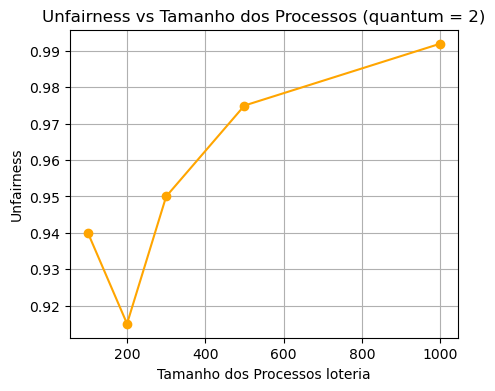

In [36]:
#resposta 3 Loteria

import matplotlib.pyplot as plt

# Tamanhos dos processos
tamanhos = [100, 200, 300, 500, 1000]

# Valores correspondentes de unfairness
unfairness = [0.94, 0.915, 0.95, 0.975, 0.992]

# Criando o gráfico
plt.figure(figsize=(5, 4))
plt.plot(tamanhos, unfairness, marker='o', linestyle='-', color='orange')

# Adicionando rótulos e título
plt.title('Unfairness vs Tamanho dos Processos (quantum = 2)')
plt.xlabel('Tamanho dos Processos ''loteria')
plt.ylabel('Unfairness')
plt.grid(True)

plt.show()




###### Resposta 4 Loteria:

Os processos com menos tickets, embora tenham tido algumas oportunidades de execução, acabaram enfrentando tempos de espera maiores. Como a probabilidade de serem escolhidos é proporcional ao número de tickets, sempre existe a possibilidade de novos processos com mais tickets surgirem, o que aumenta ainda mais a concorrência e reduz suas chances de rodar


###### Resposta 4 Loreteria




#### Sobre Stride ####

1 - Repita o cenário da 2 de loteria e faça um novo gráfico.

2 - No simulador maior, qual o efeito que ter muitos processos fazendo E/S tem no algoritmo? O que pode ser feito com a posição do processo quando ele volta de E/S?

3 - No simulador maior, rode um cenário igual para stride e loteria (com a mesma semente aleatória) e calcule tempo de resposta, de execução e __tempo de espera__ (tempo que o processo passou pronto). O que mudou entre os dois?

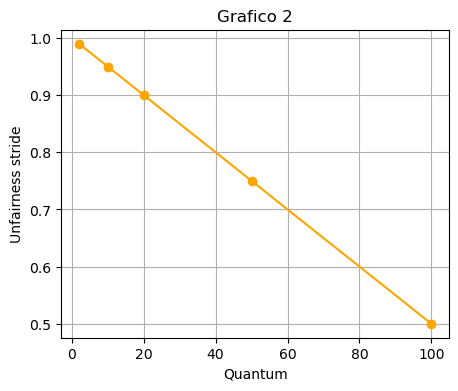

In [37]:
#RESPSOTA 1 STRIDE

import matplotlib.pyplot as plt

# Tamanhos dos processos
tamanhos = [2, 10, 20, 50, 100]

# Valores correspondentes de unfairness
unfairness = [0.990,0.950, 0.900,0.75, 0.5]

# Criando o gráfico
plt.figure(figsize=(5, 4))
plt.plot(tamanhos, unfairness, marker='o', linestyle='-', color='orange')

# Adicionando rótulos e título
plt.title('Grafico 2')
plt.xlabel('Quantum')
plt.ylabel('Unfairness stride')
plt.grid(True)

plt.show()


###### Resposta 2 Stride:


Quando um processo está bloqueado aguardando por E/S, ele não é considerado pelo escalonador Stride, que continua executando os demais processos normalmente. Ao retornar da E/S, o processo mantém o mesmo contador de passagens que tinha antes de ser bloqueado, preservando sua posição relativa na fila de execução. Isso significa que, quando um novo processo entra no sistema, ele geralmente precisa aguardar até que os processos já em execução completem sua vez, respeitando a ordem estabelecida pelo algoritmo.



###### Resposta 3 Stride:


Loteria:  
Tempo de Execuçao medio: 5.5    
Tempo de Resposta:3,5

Stride:   
Tempo de Execuçao medio: 10.5  
Tempo de Resposta: 3 

O tempo de resposta não mudou muito entre os dois, o que já indica que a ordem inicial de atendimento dos processos foi a mesma. A diferença está no tempo de execução médio. No Stride, ele mais que dobrou em relação ao da Loteria. Isso significa que o Stride foi menos eficiente na alternância.

#### Sobre MLFQ ####

1 - Rode o MLFQ no segundo simulador com duas filas e sem boost. O que aconteceu? 

2 - Quais configurações de parâmetros transformam o MLFQ no Round Robin?

3 - Rodando no primeiro simulador, faça 1 dos quatro processos ser 100\% CPU-Bound e os outros três 60\% I/O Bound. Use a configuração com 3 filas, com 5, 3 e 1 timeslices para as fila em ordem de priorida. De quanto tempo deve ser o Boost para que o processo CPU-Bound não sofra starvation e tenha CPU 1 vez a cada 20 timeslices?

4 - Teste diversas configurações de número de filas, quantum das filas e boost no simulador maior e ache a que leva ao melhor tempo de execução.

### Resposta 1 
A primeira coisa que observo é que os processos que já estavam no array de processos e tinham um tamanho grande em relação aos outros, os processos 'A' e 'B', demoraram muito mais para rodar, pois os processos novos "P1", "P2" e "P3", além de curtos eram totalmente invasivos, o que não é um problema, pois se são processos curtos e rápidos eles devem rodar e ser interagíveis assim que chegam.

`Processo P1  chegou no tempo 0 
Processo P1 entrou na fila de n° 0
P1  rodou por  2  timeslice, faltam  4
Processo P1 desceu para fila de n° 1
A  rodou por  2  timeslice, faltam  8
Processo A desceu para fila de n° 1
Processo P2  chegou no tempo 4
Processo P2 entrou na fila de n° 0
P2  rodou por  2  timeslice, faltam  6
Processo P2 desceu para fila de n° 1
B  rodou por  2  timeslice, faltam  8
Processo B desceu para fila de n° 1
Processo P3  chegou no tempo 8
Processo P3 entrou na fila de n° 0
P3  rodou por  2  timeslice, faltam  2
Processo P3 desceu para fila de n° 1
P1  rodou por  4  timeslice, faltam  0
A  rodou por  4  timeslice, faltam  4
Processo A desceu para fila de n° 1
P2  rodou por  4  timeslice, faltam  2
Processo P2 desceu para fila de n° 1
B  rodou por  4  timeslice, faltam  4
Processo B desceu para fila de n° 1
P3  fez e/s, falta  1
A  rodou por  4  timeslice, faltam  0
P2  rodou por  2  timeslice, faltam  0
Processo P3 manteve-se na fila n° 1
B  rodou por  4  timeslice, faltam  0
P3  fez e/s, falta  0
Tempo de Execuçao medio: 38.25
Tempo de Resposta:  59.5`

### Resposta 2 
Claramente, seriam:
- Número de Filas de Prioridade: 1
- Tamanho do Quantum: Fixo
- Chance de ocorrer E/S: 0

Se os parâmetros acima forem aplicados, os processos simplesmente entraram em movimento circular(round-robin) e não vão ter vantagem nem desvantagem nesse caso, afinal todos vão ter sua parcela de tempo para rodar, o que deixa o tempo de resposta totalmente degradado. Um ponto destaque a perceber é que, por conta da maneira como os novos processos são atendidos quando chegam, o tempo de resposta melhora, mas bem pouco.
Exemplo:
Workload: 'A'- 10 tam,  'B' - 10 tam, 'P1' - 6 tam, 'P2' - 8 tam, 'P3' - tam; Quantum -> 2.

``Processo P1  chegou no tempo 0
Processo P1 entrou na fila de n° 0
P1  rodou por  2  timeslice, faltam  4
Processo P1 desceu para fila de n° 0
A  rodou por  2  timeslice, faltam  8
Processo A desceu para fila de n° 0
Processo P2  chegou no tempo 4
Processo P2 entrou na fila de n° 0
P2  rodou por  2  timeslice, faltam  6
Processo P2 desceu para fila de n° 0
B  rodou por  2  timeslice, faltam  8
Processo B desceu para fila de n° 0
Processo P3  chegou no tempo 8
Processo P3 entrou na fila de n° 0
P3  rodou por  2  timeslice, faltam  6
Processo P3 desceu para fila de n° 0
P1  rodou por  2  timeslice, faltam  2
Processo P1 desceu para fila de n° 0
A  rodou por  2  timeslice, faltam  6
Processo A desceu para fila de n° 0
P2  rodou por  2  timeslice, faltam  4
Processo P2 desceu para fila de n° 0
B  rodou por  2  timeslice, faltam  6
Processo B desceu para fila de n° 0
P3  rodou por  2  timeslice, faltam  4
Processo P3 desceu para fila de n° 0
P1  rodou por  2  timeslice, faltam  0
A  rodou por  2  timeslice, faltam  4
Processo A desceu para fila de n° 0
P2  rodou por  2  timeslice, faltam  2
Processo P2 desceu para fila de n° 0
B  rodou por  2  timeslice, faltam  4
Processo B desceu para fila de n° 0
P3  rodou por  2  timeslice, faltam  2
Processo P3 desceu para fila de n° 0
A  rodou por  2  timeslice, faltam  2
Processo A desceu para fila de n° 0
P2  rodou por  2  timeslice, faltam  0
B  rodou por  2  timeslice, faltam  2
Processo B desceu para fila de n° 0
P3  rodou por  2  timeslice, faltam  0
A  rodou por  2  timeslice, faltam  0
B  rodou por  2  timeslice, faltam  0
Tempo de Execuçao medio: 44.0
Tempo de Resposta:  105.0``